## Benchmarks
This demo shows the performance of other SOTA graph embeddings methods and their limitations. Two main algoirthms tested are sub2vec and graph2vec.

To test the algorithms, a third-party dataset presented in main_demo notebook is used. 
I verify whether the embedding methods are robust to:

reinitialization

node removal

In the end of the demo graph kernels are briefly introduced, along with node2vec algo. 

In [1]:
import os,sys
import random
import numpy as np
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity

sys.path.append(os.path.realpath('lib'))
from lib.data_loader import load_local_data
from benchmarks.sub2vec import Sub2vec


## sub2vec demo

In this approach the authours were inspired by the paragraph2vec method of paragrahps embeddings. The algorithm creates sub-graph embeddings which take neighborhood or structural information (separately) into account. The neighborhood information is similar to node2vec (i.e an node ID), the structural infromation of each node is represented as a ratio of node degree to the size of  a subgraph. 

The algorithm is based on random walks, where the graph-paths track how the density of edges changes in a neighbourhood. The nodes are coded (depending on their degree/graph size ratio - structural, on their id - neighborhood) into a log scale vocabulary. To learn the final embeddings, researchers propose two methods exising in word3vec model: sub2vec-DM (predicting neigh node and graph) and sud2vec-DBON (co-occurence based learning). Negative samling is used as in word2vec. The idea of the method is the following - graphs which have common nodes should have similar embeddings.

Algo

Require: Graph G, subgraph set S = {g1, g2, . . . , gn}, length of the context window w, dimension d 

1: walkSet = {} 

2: for each gi in s do 

3: walk = RandomWalk (gi) 

4: walkSet[gi] = walk 

5: end for 

6: f = StochasticGradientDescent(walkSet, d, w) 

7: return f


In [14]:
dataset_n='aids' # the IGN  and BZR are the alternative datasets
path='data/'
X,y=load_local_data(path,dataset_n, attributes=False, use_node_deg=False)
sub2vec = Sub2vec(property='s', walkLength=1000, output='aids_walk', d=128, iter=100, windowSize=2, p=0.5, model='dm')
# the parameters chosen are the ones from the paper, I only modified the walklenght for a smalled dataset
sub2vec.obtainRandomWalks(X)
embeddings = sub2vec.calculateEmbeddings()
print(embeddings.shape)

Total vects  2000
(2000, 128)


In [3]:
# re-calculate the embeddings and demonstrate that the cosine similarity doesn't work within rounds 

In [56]:
sub2vec.obtainRandomWalks(X)
embeddings2 = sub2vec.calculateEmbeddings()


Total vects  2000


In [61]:
# display cosine similarity for first 10 embeddings
num_graphs, d = embeddings.shape
random_graphs =  np.random.randint(0, num_graphs, size=(10))
for i in random_graphs:
    print(f"Similarity of two graphs within rounds is {cosine_similarity(embeddings[i,:].reshape(1, -1), embeddings2[i,:].reshape(1, -1))}")


Similarity of two graphs within rounds is [[0.06005514]]
Similarity of two graphs within rounds is [[0.13349625]]
Similarity of two graphs within rounds is [[0.09431593]]
Similarity of two graphs within rounds is [[0.05708874]]
Similarity of two graphs within rounds is [[-0.0155139]]
Similarity of two graphs within rounds is [[0.17029813]]
Similarity of two graphs within rounds is [[0.12372799]]
Similarity of two graphs within rounds is [[-0.03390585]]
Similarity of two graphs within rounds is [[0.16328917]]
Similarity of two graphs within rounds is [[0.24532312]]


In [15]:
# function to calculate all the values and display stats
def meanstd_similarity(emb1, emb2):
    res_similarity = []
    num_graphs, d = emb1.shape
    for i in range(num_graphs):
        res_similarity.append(cosine_similarity(emb1[i,:].reshape(1, -1), emb2[i,:].reshape(1, -1))[0][0])
    print(f"Mean cosine similarity is {np.mean(res_similarity)}, std is {np.std(res_similarity)} for the pairwise comparison if {num_graphs} graphs")  


In [35]:
meanstd_similarity(emb1 = embeddings, emb2 = embeddings2)

Mean cosine similarity is 0.11877530068159103, std is 0.15287145972251892 for the pairwise comparison if 2000 graphs


In [33]:
# and now calculate the embeddings in one go (in one round) and check whether they are similar or not this way

In [25]:
X_double = np.hstack((X,X))
sub2vec.obtainRandomWalks(X_double)
embeddings1_2 = sub2vec.calculateEmbeddings()

Total vects  4000


In [36]:
embeddings1 = embeddings1_2[:2000,:]
embeddings2 = embeddings1_2[2000:,:]
num_graphs, d = embeddings1.shape
random_graphs =  np.random.randint(0, num_graphs, size=(10))
for i in random_graphs:
    print(f"Similarity of two graphs from the same round is {cosine_similarity(embeddings1[i,:].reshape(1, -1), embeddings2[i,:].reshape(1, -1))}")
# much better but still very small at times, not consistent and these are the exactly same graphs!

Similarity of two graphs from the same round is [[0.9857781]]
Similarity of two graphs from the same round is [[0.98320913]]
Similarity of two graphs from the same round is [[0.9268111]]
Similarity of two graphs from the same round is [[0.95995694]]
Similarity of two graphs from the same round is [[0.9697628]]
Similarity of two graphs from the same round is [[0.8995649]]
Similarity of two graphs from the same round is [[0.93944114]]
Similarity of two graphs from the same round is [[0.9864575]]
Similarity of two graphs from the same round is [[0.94997174]]
Similarity of two graphs from the same round is [[0.9463763]]


In [37]:
meanstd_similarity(emb1 = embeddings1, emb2 = embeddings2)

Mean cosine similarity is 0.9380630850791931, std is 0.10485057532787323 for the pairwise comparison if 2000 graphs


In [69]:
# I modified the graphs removing one single (always connected only to one or max two neighbors node)

In [16]:
from copy import deepcopy
def remove_single_node(graphs_list):
    ''' function just removes a random node from a graph which has one or two neighbors'''
    modified_graphs = []
    for graph in graphs_list:
        nx_graph = graph.nx_graph # get the graph
        degree = nx_graph.degree
        degreeDict = dict(degree)
        random_nodes_to_delete = []
        # pick nodes which have 1 neighbor only
        for node, degree in degreeDict.items():
            if degree == 1:
                random_nodes_to_delete.append(node)
        # else pick nodes which have 2 neighbors
        if len(random_nodes_to_delete) == 0:
            for node, degree in degreeDict.items():
                if degree == 2:
                    random_nodes_to_delete.append(node)
        if len(random_nodes_to_delete)==0:
            modified_graphs.append(graph) # leave the graph as it was
            print('A graph which has no nodes with degrees 1 & 2 detected')
        else:
            copy_graph = deepcopy(graph) # create a new deep copy
            copy_graph.nx_graph.remove_node(random.choice(random_nodes_to_delete))

            modified_graphs.append(copy_graph)
        #
    return modified_graphs


In [39]:
# a small unit test of a function above
subset_X = X[:10]
modified_subset = remove_single_node(subset_X)
print('done')
for i in range(10):
    print(f"graph before modif has {len(subset_X[i].nx_graph)} and after modif {len(modified_subset[i].nx_graph)}")


done
graph before modif has 47 and after modif 46
graph before modif has 11 and after modif 10
graph before modif has 9 and after modif 8
graph before modif has 10 and after modif 9
graph before modif has 16 and after modif 15
graph before modif has 9 and after modif 8
graph before modif has 11 and after modif 10
graph before modif has 10 and after modif 9
graph before modif has 17 and after modif 16
graph before modif has 9 and after modif 8


And now check if the resulting embeddings are different

In [17]:
X_modified =  remove_single_node(X)
X_modified =  remove_single_node(X_modified) #remove second node
X_original_and_modidied = np.hstack((X,X_modified))
sub2vec.obtainRandomWalks(X_original_and_modidied)
embeddings1_2 = sub2vec.calculateEmbeddings()

A graph which has no nodes with degrees 1 & 2 detected
A graph which has no nodes with degrees 1 & 2 detected
Total vects  4000


In [18]:
embeddings1 = embeddings1_2[:2000,:]
embeddings2 = embeddings1_2[2000:,:]
num_graphs, d = embeddings1.shape
random_graphs =  np.random.randint(0, num_graphs, size=(10))
for i in random_graphs:
    print(f"Similarity of two graphs with a single node removed is {cosine_similarity(embeddings1[i,:].reshape(1, -1), embeddings2[i,:].reshape(1, -1))}")
# sometimes the change is significant.

Similarity of two graphs with a single node removed is [[0.8034649]]
Similarity of two graphs with a single node removed is [[0.84938514]]
Similarity of two graphs with a single node removed is [[0.9531997]]
Similarity of two graphs with a single node removed is [[0.8750119]]
Similarity of two graphs with a single node removed is [[0.8334495]]
Similarity of two graphs with a single node removed is [[0.83803713]]
Similarity of two graphs with a single node removed is [[0.90148735]]
Similarity of two graphs with a single node removed is [[0.45095015]]
Similarity of two graphs with a single node removed is [[0.6835461]]
Similarity of two graphs with a single node removed is [[0.7864645]]


In [19]:
meanstd_similarity(emb1 = embeddings1, emb2 = embeddings2)

Mean cosine similarity is 0.7883523106575012, std is 0.18132445216178894 for the pairwise comparison if 2000 graphs


### Conclusion Sub2Vec
The results are not too bad, however, for some cases it is still a lot for the case when we need to compare the vectors. A complete disaster between runs - the embeddings are not coherent at all. They are probably affected quite a lot by the random walk. Quite sensitive to the removal of nodes.

And the main problem with this method - we cannot really use the attributes which are [potentially] extremely important.

# Graph2Vec demo

A method representing entire graphs as fixed length feature vectors - inspired by  neural document embedding models, the authors extend the same to learn graph embeddings.graph2vec proposes to view an entire graph as a document and the rooted subgraphs around every node in the graph as words that compose the document and extend document embedding neural networks to learn representations of entire graphs.

An input of algorithms is a set of labeled or unlabeled graphs, in the case of unlabeled graphs  nodes are labeled  with their degree. In graph2vec,the are graphs analogical to documents that are composed of rooted subgraphs which, in turn, are
analogical words from a special language and extend document embedding models to learn graph embeddings. The main motivation behind this idea is that structurally similar graphs will be close to each other in the embedding space. 

Algorithm: 

input -   Set of graphs

1) extract rooted subgraphs and assign a unique
label for all the rooted subgraphs in the vocabulary 

2) these hashed features (tags ( Weisfeiler-Lehman kernel decomposes a graph into subtrees ->https://www.cse.wustl.edu/~muhan/papers/KDD_2017.pdf) and node degrees (words) describe each sub-graph 

3) train a doc2vec skip-gram model using negative sampling. DBOW model is used.

In [21]:
import hashlib
import tqdm
from joblib import Parallel, delayed
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from benchmarks.graph2vec import feature_extractor # I modified the original code by the authors to directly use it on our data

In [ ]:
dataset_n = 'aids'
path = 'data/'
X, y = load_local_data(path, dataset_n, attributes=False, use_node_deg=False)
X = list(X)
print("\nFeature extraction started.\n")
document_collections = Parallel(n_jobs=1)(delayed(feature_extractor)(g,2, str(i)) for i, g in enumerate(X))
print("\nOptimization started.\n")

model = Doc2Vec(document_collections, vector_size = 128, window = 2, min_count = 5, dm = 0,
                sample = 0.0001, workers = 10, epochs = 20, alpha =0.025)
embeddings = model.docvecs.vectors_docs
print(f"Returned embeddings shape is {embeddings.shape}")

In [45]:
document_collections2 = Parallel(n_jobs=1)(delayed(feature_extractor)(g,2, str(i)) for i, g in enumerate(X))
model = Doc2Vec(document_collections2, vector_size = 128, window = 2, min_count = 5, dm = 0,
                sample = 0.0001, workers = 10, epochs = 20, alpha =0.025)
embeddings2 = model.docvecs.vectors_docs

Check the similarity of the graph embeddings within the runs

In [46]:
num_graphs, d = embeddings.shape
random_graphs =  np.random.randint(0, num_graphs, size=(10))
for i in random_graphs:
    print(f"Similarity of two graphs within rounds is {cosine_similarity(embeddings[i,:].reshape(1, -1), embeddings2[i,:].reshape(1, -1))}")


Similarity of two graphs within rounds is [[0.848712]]
Similarity of two graphs within rounds is [[0.8972695]]
Similarity of two graphs within rounds is [[0.8492506]]
Similarity of two graphs within rounds is [[0.8924836]]
Similarity of two graphs within rounds is [[0.77217966]]
Similarity of two graphs within rounds is [[0.7804389]]
Similarity of two graphs within rounds is [[0.87400985]]
Similarity of two graphs within rounds is [[0.65968746]]
Similarity of two graphs within rounds is [[0.8078866]]
Similarity of two graphs within rounds is [[0.8581012]]


In [47]:
meanstd_similarity(emb1 = embeddings, emb2 = embeddings2)

Mean cosine similarity is 0.8272595405578613, std is 0.05931011587381363 for the pairwise comparison if 2000 graphs


In [ ]:
# Similarity in a  one run within the same graphs

In [48]:
X_double = np.hstack((X,X))
document_collections = Parallel(n_jobs=1)(delayed(feature_extractor)(g,2, str(i)) for i, g in enumerate(X_double))
model = Doc2Vec(document_collections, vector_size = 128, window = 2, min_count = 5, dm = 0,
                sample = 0.0001, workers = 10, epochs = 20, alpha =0.025)
embeddings1_2 = model.docvecs.vectors_docs

In [50]:
embeddings1 = embeddings1_2[:2000,:]
embeddings2 = embeddings1_2[2000:,:]
num_graphs, d = embeddings1.shape
random_graphs =  np.random.randint(0, num_graphs, size=(10))
for i in random_graphs:
    print(f"Similarity of two graphs from the same round is {cosine_similarity(embeddings1[i,:].reshape(1, -1), embeddings2[i,:].reshape(1, -1))}")
# this actually looks pretty good! So the WL labeling gives pretty good results in comparison with random walks 

Similarity of two graphs from the same round is [[0.9925771]]
Similarity of two graphs from the same round is [[0.9945583]]
Similarity of two graphs from the same round is [[0.9765564]]
Similarity of two graphs from the same round is [[0.9957062]]
Similarity of two graphs from the same round is [[0.98460644]]
Similarity of two graphs from the same round is [[0.9907874]]
Similarity of two graphs from the same round is [[0.98394835]]
Similarity of two graphs from the same round is [[0.9813585]]
Similarity of two graphs from the same round is [[0.9954908]]
Similarity of two graphs from the same round is [[0.98716354]]


In [51]:
meanstd_similarity(emb1 = embeddings1, emb2 = embeddings2)

Mean cosine similarity is 0.9899162650108337, std is 0.01579388417303562 for the pairwise comparison if 2000 graphs


Finally, check if the algo is robust for node removal 

In [22]:
#X_modified =  remove_single_node(X)
X_original_and_modidied = np.hstack((X,X_modified))
document_collections = Parallel(n_jobs=1)(delayed(feature_extractor)(g,2, str(i)) for i, g in enumerate(X_original_and_modidied))
model = Doc2Vec(document_collections, vector_size = 128, window = 2, min_count = 5, dm = 0,
                sample = 0.0001, workers = 10, epochs = 20, alpha =0.025)
embeddings1_2 = model.docvecs.vectors_docs


In [23]:
embeddings1 = embeddings1_2[:2000,:]
embeddings2 = embeddings1_2[2000:,:]
num_graphs, d = embeddings1.shape
random_graphs =  np.random.randint(0, num_graphs, size=(10))
for i in random_graphs:
    print(f"Similarity of two graphs from the same round is {cosine_similarity(embeddings1[i,:].reshape(1, -1), embeddings2[i,:].reshape(1, -1))}")
# this is no longer good

Similarity of two graphs from the same round is [[0.59017116]]
Similarity of two graphs from the same round is [[0.56813]]
Similarity of two graphs from the same round is [[0.69048107]]
Similarity of two graphs from the same round is [[0.33703303]]
Similarity of two graphs from the same round is [[0.6379502]]
Similarity of two graphs from the same round is [[0.4971013]]
Similarity of two graphs from the same round is [[0.7801858]]
Similarity of two graphs from the same round is [[0.40345317]]
Similarity of two graphs from the same round is [[0.9749607]]
Similarity of two graphs from the same round is [[0.50495076]]


In [24]:
meanstd_similarity(emb1 = embeddings1, emb2 = embeddings2)

Mean cosine similarity is 0.6250722408294678, std is 0.17743416130542755 for the pairwise comparison if 2000 graphs


Not really robust to the graph modification, so this is a limitation of graph2vec. Ok within two runs, which makes this method more interesting for further work.

# Conclusion on two embedding methods

Main disadvantages:
Both algorithms do not take attributes into account ( they can only handle discreet attributes)
they are very dependable onto the reinitialization of the random walks and minor graph changes.

It will be awesome to allow to use node attributes of graphs in resulting embeddings. None of this algo uses weights of the edges either. 

It will be nice to have constant embeddings withing algorithm run but in the same moment to make them robust for minor graph 
changes. There are methods which allow for that (for example, subgraph matching kernel) - but they way too long to compute for a real-case scenario.
If we could have had an embedding having better properties than the existing ones - it can be very interesting for some applications.


# Node2Vec

In [2]:
from benchmarks.node2vec.node2vec import Node2Vec
import matplotlib.pyplot as plt

This approach is very similar to word2vec embedding and is a direct improuvement of DeepWalk. The nodes are embedded based on their proximity and inter-connection, so connected node results in similar embeddings. The new idea in node2vec is the new sampling strategy allowing to explore the node neighborhood.

The algorithm will take a big graph as an input, where nodes have unique labels. 
Then each node will be embedded and assigned a key-word (it's ID), and we can retrieve the embedding of the node using this ID.

The algo is the following:

1) For all nodes perform the pseudo-random walk of length n N-times. 

2) Calculate the embedding vectors for each node based on the walks - skip-gram Word2vec on walks.

This way sentences are walks, formed by words (node ids) and we calculate an embedding based on that.

A demo on node2vec can be found here [https://github.com/eliorc/Medium/blob/master/Nod2Vec-FIFA17-Example.ipynb].
And I tried a small test of node2vec algo on a subset of graphs I have. 


In [11]:
dataset_n='aids' # the IGN  and BZR are the alternative datasets
path='data/'
X,y=load_local_data(path,dataset_n, attributes=False, use_node_deg=False)
#create a single graph from several graphs 
subset_X = X[:10]
# make a new graph as a combo of 10 graphs
G=nx.Graph()
for i in range(10):
    G.add_nodes_from(subset_X[i].nx_graph.nodes(data=False))
    G.add_edges_from(subset_X[i].nx_graph.edges)
    
# change all node attributes to unique node id_s
atr = [range(len(G))]
nx.set_node_attributes(G, atr, 'attr_name')

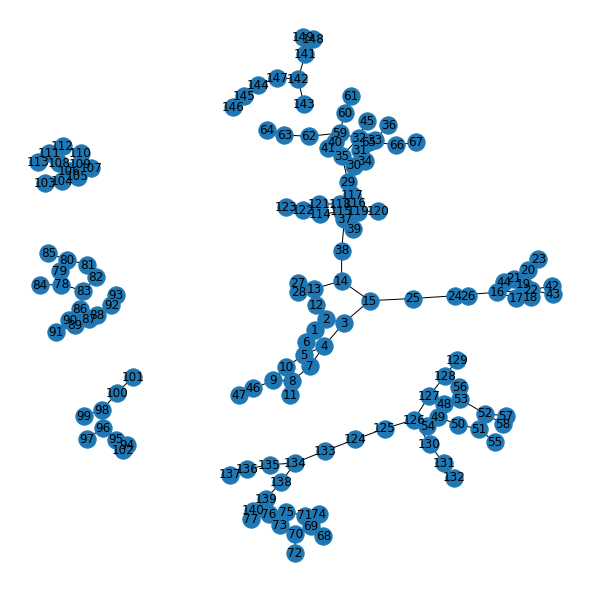

In [12]:
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels = True)

In [13]:
EMBEDDING_FILENAME = 'embeddings.emb'
EMBEDDING_MODEL_FILENAME = 'embeddings.model'

node2vec = Node2Vec(G, dimensions=54, walk_length=30, num_walks=10, workers=4)

## if d_graph is big enough to fit in the memory, pass temp_folder which has enough disk space
# Note: It will trigger "sharedmem" in Parallel, which will be slow on smaller graphs
# node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4, temp_folder="/mnt/tmp_data")

# Embed
model = node2vec.fit(window=10, min_count=1, batch_words=20)# Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes


Computing transition probabilities: 100%|█████████████████████████████████████████| 149/149 [00:00<00:00, 21341.78it/s]


The networks learns the embedding for key-words, which are in this case node degrees.
It can be changes so we use not the degrees but node ids, I need to look at it more.

In [17]:
model.wv.vocab

{'2': <gensim.models.keyedvectors.Vocab at 0x18abe881088>,
 '3': <gensim.models.keyedvectors.Vocab at 0x18abe881148>,
 '1': <gensim.models.keyedvectors.Vocab at 0x18abe881108>,
 '4': <gensim.models.keyedvectors.Vocab at 0x18abe881188>}

In [21]:
v2_1 = model.wv.get_vector('2')

In [ ]:
# rerun and test similarity of the vectors to start with

In [23]:
node2vec = Node2Vec(G, dimensions=54, walk_length=30, num_walks=10, workers=4)

## if d_graph is big enough to fit in the memory, pass temp_folder which has enough disk space
# Note: It will trigger "sharedmem" in Parallel, which will be slow on smaller graphs
# node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4, temp_folder="/mnt/tmp_data")

# Embed
model = node2vec.fit(window=10, min_count=1, batch_words=20)# Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)
v2_2 = model.wv.get_vector('2')

Computing transition probabilities: 100%|█████████████████████████████████████████| 149/149 [00:00<00:00, 29884.82it/s]


In [26]:
print(f"Similarity of two graphs 'key-words' from two different rounds is {cosine_similarity(v2_1.reshape(1, -1), v2_2.reshape(1, -1))}")

Similarity of two graphs 'key-words' from two different rounds is [[0.94477373]]


## Conclusion on Node2Vec

This algorithm is useful to create embeddings for nodes based on their neigborhood (hence, based on their structural role in the graph). However, once again, it is not using the attributes of the nodes and can handle only discreet attributes.

In addition,  it is not clear how can we use it in our scenario of graph-mathing, although there are ways (to calculate an average embedding for all nodes being one of them).

## Graph Kernels

The problem of accurately measuring the similarity between graphs is at the core of many applications in a variety of disciplines. Graph kernels have recently emerged as a promising approach to this problem. There are now many kernels, each focusing on different structural aspects of graphs.

The main interest using kernels is the fact that many are designed to work with node and edge attributes  -> hence, they can exploit more important information than the exisitng embedding methods and are better to use for matching.

An example of a kernel function:
Graph Hopper Kernel. Given two graphs, the GraphHopper kernel compares shortest paths between pairs of vertices from the two graphs [FKP+13]. The kernel takes into account both path lengths and the vertices encountered while "hopping" along shortest paths. The kernel is equivalent to a weighted sum of node kernels

The prior tests on our data has shown the superiority of the Subgraph Matching Kernel over other tested graph kernels (GraphHopper,Hadamard Code Kernel, ODD-STh Kernel,SVM Theta Kernel etc)

I use the grakel library for all kernel calculations:
https://ysig.github.io/GraKeL/latest/user_manual/longer_introduction.html

### Subgraph Matching Kernel

The subgraph matching kernel counts the number of matchings between subgraphs of bounded size in two graphs [kriege2012subgraph]. The kernel is very general since it can be applied to graphs that contain node labels, edge labels, node attributes or edge attributes.

Let G be a set of graphs. We assume that the graphs that are contained in the set are labeled or attributed. Specifically, let ℓ:V∪E→L be a labeling function that assigns either discrete labels or continuous attributes to vertices and edges. A graph isomorphism between two labeled/attributed graphs G=(V,E) and G′=(V′,E′) is a bijection ϕ:V→V′ that preserves adjacencies, ie ∀v,u∈V:(v,u)∈E⇔(ϕ(v),ϕ(u))∈E′, and labels, ie if ψ∈V×V→V′×V′ is the mapping of vertex pairs implicated by the bijection ϕ such that ψ((v,u))=(ϕ(v),ϕ(u)), then, the conditions ∀v∈V:ℓ(v)≡ℓ(ϕ(v)) and ∀e∈E:ℓ(e)≡ℓ(ψ(e)) must hold, where ≡ denotes that two labels are considered equivalent.

Given two graphs G=(V,E) and G′=(V′,E′), let B(G,G′) denote the set of all bijections between sets S⊆V and S′⊆V′, and let λ:B(G,G′)→R+ be a weight function. The subgraph matching kernel is defined as

k(G,G′)=∑ϕ∈B(G,G′)λ(ϕ)∏v∈SκV(v,ϕ(v))∏e∈S×SκE(e,ψ(e))
where S=dom(ϕ) and κV,κE are kernel functions defined on vertices and edges, respectively.

The instance of the subgraph matching kernel that is obtained if we set the κV,κE functions as follows

κV(v,v′)κE(e,e′)={1,0,if ℓ(v)≡ℓ(v′),otherwise and={1,0,if e∈E∧e′∈E′∧ℓ(e)≡ℓ(e′) or e∉E∧e′∉E′,otherwise.
is known as the common subgraph isomorphism kernel. This kernel counts the number of isomorphic subgraphs contained in two graphs.

Paper link:
https://arxiv.org/ftp/arxiv/papers/1206/1206.6483.pdf

In [2]:
from grakel.kernels import SubgraphMatching
from grakel import GraphKernel
from lib.grakels_dataloader import  read_data

C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [51]:
dataset_n='AIDS' # the IGN  and BZR are the alternative datasets
path='D:/projects/graph_transformer/data/AIDS/'
X = read_data(name = dataset_n,
        with_classes=False,
        prefer_attr_nodes=True,
        prefer_attr_edges=False,
        produce_labels_nodes=False,
        as_graphs=False,
        is_symmetric=1, path =path)

In [30]:
sbm_kernel = GraphKernel(kernel = [{"name": "subgraph_matching"}], normalize = True) #Nystroem=20 Nystroem is very well known method, for approximating kernel matrices on huge datasets.
#k:int, default=5
#lw:str, valid_values={“uniform”, “increasing”, “decreasing”, “strong_decreasing”},
#default=”uniform” | iterable, size=k+1,
#| callable, num_of_arguments=1, argument_type=int
#The lambda weights applied to the clique sizes.
#kv:function (vertex_label, `vertex_label, -> number), or None
#default=:math:`k_{v}^{default}(l(a), l(b))= delta(l(a), l(b))`
#The kernel function between two vertex_labels. If no function is provided, this is equivalent with not taking into account node labels.
#ke:function (edge_label, edge_label -> number),
#default=:math:`k_{e}^{default}(l(e), l(e’))= delta(l(e), l(e’))`
#The kernel function between two edge_labels. If no function is provided, this is equivalent with not taking into account edge labels.

In [31]:
from  sklearn.preprocessing import MinMaxScaler
def mean_similarity_graph(D):
    sim = 0
    scaler = MinMaxScaler()
    m = D.shape[0]
    for i in range(m):
        D[i,:] =  scaler.fit_transform(D[i,:].reshape(-1, 1)).reshape(D[i,:].shape)
        sim+=D[i,i] # todo: maybe do a min max normalization here
    return sim/m    

In [32]:
sbm_kernel.fit_transform(X.data) # fit on the initial data

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [91]:
### Test on node removal

In [62]:
# from lib.grakels_dataloader import remove_single_node_grakels
from random import randint
def remove_single_node_grakels(graph):
    for g in graph.data:
        num_nodes =len(g[1])
        node_to_delete = randint(0,num_nodes)
        if node_to_delete in g[1]: del g[1][node_to_delete] # delete node
        # delete all edges
        new_set = set()
        for el in g[0]:
            if el[0]!=node_to_delete and el[1] != node_to_delete:
                new_set.add(el)
            else:
                if el in g[2]: del g[2][el]  # delete node
        g[0] = new_set
    return graph
X_modified = read_data(name = dataset_n,
        with_classes=False,
        prefer_attr_nodes=True,
        prefer_attr_edges=False,
        produce_labels_nodes=False,
        as_graphs=False,
        is_symmetric=1, path =path)

X_modified = remove_single_node_grakels(X_modified)

In [34]:
# transform on new data - will produce the matrix of distances
X_Xm_similarity_matrix = sbm_kernel.transform(X_modified.data) # Rntest×Rntrain

In [35]:
random_graphs =  np.random.randint(0, len(X_Xm_similarity_matrix), size=(10))
for i in random_graphs:
     print(f"Similarity of two graphs with a single node removed is {X_Xm_similarity_matrix[i,i]}")

Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0
Similarity of two graphs with a single node removed is 1.0


In [36]:
print(f"Similarity of two graphs with a single node removed and all attributes modified is {mean_similarity_graph(X_Xm_similarity_matrix)}")

Similarity of two graphs with a single node removed and all attributes modified is 1.0


So sub-graph matching is really fine with node removal etc as long as the attributes are not changed. 
What will happen if they will change?

In [53]:
## test on attribute modifications
def modify_attributes_grakels(graph):
    for g in graph.data:
        for i in g[1].keys():
            for k in range(len(g[1][i])):
                g[1][i][k]+=random.random() # add random val to the attribute
    return graph
X_modified =  modify_attributes_grakels(X_modified)

In [111]:
X_Xm_similarity_matrix = sbm_kernel.transform(X_modified.data) # Rntest×Rntrain

In [117]:
random_graphs =  np.random.randint(0, len(X_Xm_similarity_matrix), size=(10))
for i in random_graphs:
     print(f"Similarity of two graphs with a single node removed and all attributes modified is {X_Xm_similarity_matrix[i,i]}")

Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0
Similarity of two graphs with a single node removed and all attributes modified is 0.0


This shows that the kernel cannot deal with a change of the attributes. Although, this can be fixed by getting an appropriate kernel to compare them. Here is an example.

In [ ]:
# it is also possible to simplify the calculations of graph kernels but usually it also reduces their accuracy
# and any sklearn kernel can be later used on the obtained features
from sklearn.metrics.pairwise import pairwise_kernels
dataset_n='AIDS' # the IGN  and BZR are the alternative datasets
path='D:/projects/graph_transformer/data/AIDS/'
X = read_data(name = dataset_n,
        with_classes=False,
        prefer_attr_nodes=True,
        prefer_attr_edges=False,
        produce_labels_nodes=False,
        as_graphs=False,
        is_symmetric=1, path =path)

#GH_kernel = SubgraphMatching(normalize=False, verbose = True) # by defenition function kv is int(a == b)
def _comp_func(a, b):
    """Calculate the new distance function for labels."""
    return sum([abs(a_i - b_i)<0.2 for a_i, b_i in zip(a, b)]) # we can define any function we want on the attributes 



sbm_kernel = GraphKernel(kernel = [{"name": "subgraph_matching", "kv":_comp_func}], normalize = True, Nystroem=10) #Nystroem=20 Nystroem is very well known method, for approximating kernel matrices on huge datasets.
X_fitted = sbm_kernel.fit_transform(X.data) # fit on the initial data

X_modified = read_data(name = dataset_n,
        with_classes=False,
        prefer_attr_nodes=True,
        prefer_attr_edges=False,
        produce_labels_nodes=False,
        as_graphs=False,
        is_symmetric=1, path =path)

X_modified =  modify_attributes_grakels(X_modified)
Xm_fitted = sbm_kernel.transform(X_modified.data) # Rntest×Rntrain
X_Xm_similarity_matrix = pairwise_kernels(X_fitted, Xm_fitted, metric='cosine') # compare now the features
random_graphs =  np.random.randint(0, len(X_Xm_similarity_matrix), size=(10))
for i in random_graphs:
     print(f"Similarity of two graphs with a single node removed and all attributes modified is {X_Xm_similarity_matrix[i,i]}")

In [16]:
print(f"Similarity of two graphs with a single node removed and all attributes modified is {mean_similarity_graph(X_Xm_similarity_matrix)}")

Similarity of two graphs with a single node removed and all attributes modified is 0.5973781044868414


### Graphlet sampling kernels

The graphlet sampling kernel decomposes graphs into graphlets (i.e. small subgraphs with k nodes where k∈{3,4,5,…}) [prvzulj2007biological] and counts matching graphlets in the input graphs.
Let G={graphlet1,graphlet2,…,graphletr} be the set of size-k graphlets.
Let also fG∈Nr be a vector such that its i-th entry is equal to the frequency of occurrence of graphlet i in G, fG,i=#(graphleti⊑G). Then, the graphlet kernel is defined as follows:

k(Gi,Gj)=f(⊤ransopose(Gi)) f(Gj)

In [54]:
gs_kernel = GraphKernel(kernel=dict(name="graphlet_sampling", sampling=dict(n_samples=15)),normalize = True)

In [60]:
gs_kernel.fit_transform(X.data) # Rntest×Rntrain
X_modified =  modify_attributes_grakels(X_modified)
X_Xm_similarity_matrix = gs_kernel.transform(X_modified.data) # Rntest×Rntrain
random_graphs =  np.random.randint(0, len(X_Xm_similarity_matrix), size=(10))
for i in random_graphs:
     print(f"Similarity of two graphs with a single node removed and all attributes modified is {X_Xm_similarity_matrix[i,i]}")
print(f"Mean similarity of two graphs with a single node removed and all attributes modified is {mean_similarity_graph(X_Xm_similarity_matrix)}")

Similarity of two graphs with a single node removed and all attributes modified is 0.5516902572256424
Similarity of two graphs with a single node removed and all attributes modified is 0.6285582471700375
Similarity of two graphs with a single node removed and all attributes modified is 0.6666666666666666
Similarity of two graphs with a single node removed and all attributes modified is 0.6291342872277007
Similarity of two graphs with a single node removed and all attributes modified is 0.7429329562106962
Similarity of two graphs with a single node removed and all attributes modified is 0.6616167640139134
Similarity of two graphs with a single node removed and all attributes modified is 0.6191134022561045
Similarity of two graphs with a single node removed and all attributes modified is 0.9767328030946411
Similarity of two graphs with a single node removed and all attributes modified is 0.66246293696866
Similarity of two graphs with a single node removed and all attributes modified is 0

### Edge Histogram Kernel

The edge histogram kernel is a basic linear kernel on edge label histograms. The kernel assumes edge-labeled graphs. Let G be a collection of graphs, and assume that each of their edges comes from an abstract edge space E. Given a set of node labels L, ℓ:E→L is a function that assigns labels to the edges of the graphs. Assume that there are d labels in total, that is d=|L|. Then, the edge label histogram of a graph G=(V,E) is a vector f=(f1,f2,…,fd), such that fi=|{(v,u)∈E:ℓ(v,u)=i}| for each i∈L. Let f,f′ be the edge label histograms of two graphs G,G′, respectively. 
The edge histogram kernel is then defined as the linear kernel between f and f′, that is

k(G,G′)=⟨f,f′⟩
The complexity of the edge histogram kernel is linear in the number of edges of the graphs.

In [64]:
eh_kernel = GraphKernel(kernel=dict(name="edge_histogram"),normalize = True)
eh_kernel.fit_transform(X.data) # Rntest×Rntrain
X_Xm_similarity_matrix = eh_kernel.transform(X_modified.data) # Rntest×Rntrain
random_graphs =  np.random.randint(0, len(X_Xm_similarity_matrix), size=(10))
for i in random_graphs:
     print(f"Similarity of two graphs with a single node removed and all attributes modified is {X_Xm_similarity_matrix[i,i]}")
print(f"Mean similarity of two graphs with a single node removed and all attributes modified is {mean_similarity_graph(X_Xm_similarity_matrix)}")

Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Similarity of two graphs with a single node removed and all attributes modified is 1.0
Mean similarity of two graphs with a single node removed and all attributes modified is 0.9999998797946004


## Conclusion on graph kernels (based on sub-graph matching but generalizable)
The main issue of the graph Kernels is the time complexity.
The runtime of the subgraph matching kernel depends on the number of cliques in the product graph. The worst-case runtime complexity of the kernel when considering subgraphs of size up to k is O(knk+1), where n=|V|+|V′| is the sum of the number of vertices of the two graphs.
If we are testing the graph kernel for a test graph (when it was already fitted), the time complexity is not a very big issue.
Otherwise, the exact sub-graph matching seem to show very good results unless the attributes are modified. 

There are lots of kernels to test and try and indeed I cannot say that I understand them very good, but they do not contain any 'learning' unlike the graph embedding methods. They can definetively be used for our retrieval scenario.


